# **Projet Fédérateur**
## *IMRANE OU EL FAQUIR*
### **Diagnostic du cancer de la peau**

### Importing Libraries

In [1]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from keras.models import Sequential
from keras.layers import Activation, BatchNormalization, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.applications.resnet import preprocess_input
from keras_preprocessing.image import ImageDataGenerator

### Function for loading dataset

In [2]:
def load_dataset(path: str):
    dir = Path(path)
    filepaths = list(dir.glob(r'**/*.jpg'))
    labels = list(map(lambda l: os.path.split(os.path.split(l)[0])[1], filepaths))
    filepaths = pd.Series(filepaths, name='FilePaths').astype(str)
    labels = pd.Series(labels, name='Labels').astype(str)
    df = pd.merge(filepaths, labels, right_index=True, left_index=True)
    return df.sample(frac=1).reset_index(drop=True)

### Unzip dataset.zip file and loading images

In [ ]:
!unzip /content/drive/MyDrive/S5/dataset.zip

In [5]:
df = load_dataset('/content/dataset/Train/')

In [6]:
df.head(2)

,FilePaths,Labels
0,/content/dataset/Train/melanoma/ISIC_0010648.jpg,melanoma
1,/content/dataset/Train/melanoma/ISIC_0011140.jpg,melanoma


## Viewing Dataset Labels

In [7]:
labels_count = df['Labels'].value_counts(ascending=True)

In [8]:
labels_count

seborrheic keratosis           77
dermatofibroma                 95
actinic keratosis             114
vascular lesion               139
squamous cell carcinoma       181
nevus                         357
basal cell carcinoma          376
melanoma                      438
pigmented benign keratosis    462
Name: Labels, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


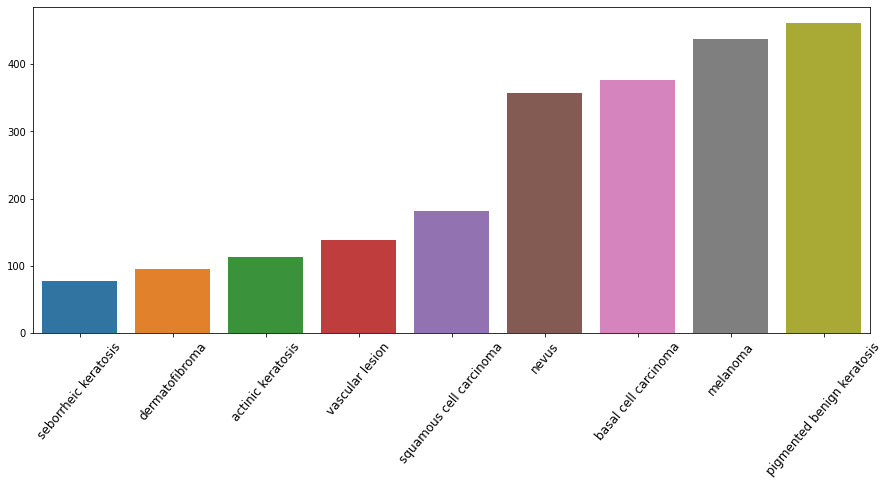

In [9]:
fig = plt.figure(figsize=(15, 6))
s = sns.barplot(labels_count.index,labels_count.values)
f = s.set_xticklabels(s.get_xticklabels(), fontsize = 12, rotation = 50)

In [10]:
# This function is for plotting images per label
def plot_images_per_label(df, label, cols: int, size: tuple):
    fig, axs = plt.subplots(nrows=1, ncols=cols, figsize=size)
    cntMax = cols
    cntCur = 0
    for index, row in df.iterrows():
        if(row['Labels'] == label and cntCur < cntMax):
            axs[cntCur].imshow(plt.imread(df.FilePaths[index]))
            axs[cntCur].set_title(df.Labels[index])

            cntCur += 1
        else:
            if(cntCur >= cntMax):
                break
    plt.tight_layout()
    plt.show()

In [11]:
labels = sorted(df['Labels'].unique())
dictionnary = dict()
for label in labels:
    dictionnary.update({label:df[df.Labels == label].iloc[0][0]})

### Plotting images of the differents skin cancer types

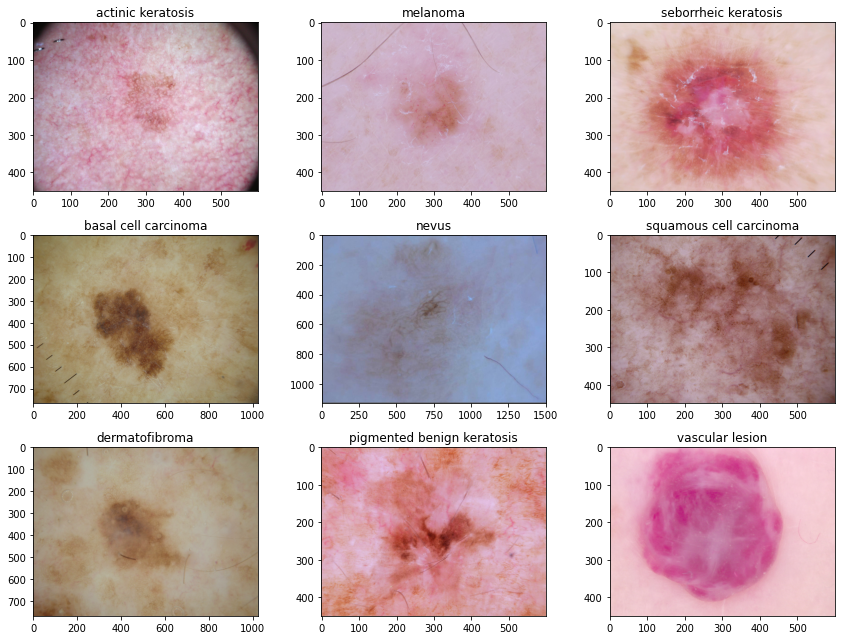

In [13]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(12,9))
keys = list(dictionnary.keys())
for i in range(3):
    for j in range(3):
        axs[i][j].imshow(plt.imread(dictionnary[keys[j + 3*(i%3)]]))
        axs[j][i].set_title(keys[j + 3*(i%3)])
plt.tight_layout()
plt.show()

## Split the dataset into Train- and Val-datasets
### stratified train and val (20%) datasets

In [37]:
X_train, X_val = train_test_split(df, test_size=0.2, stratify=df['Labels'], random_state=1)

In [38]:
print('Train Data: ', X_train.shape)
print('Val Data: ', X_val.shape)

Train Data:  (1791, 2)
Val Data:  (448, 2)


### Imrage preprocessing
We specify the batch size which (BATCH_SIZE) is the number of images per iteration, the image size (IMG_SIZE) and the number of epochs (EPOCHS)

In [39]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
EPOCHS = 50

### Image preprocessing

In [40]:
img_data_gen = ImageDataGenerator(shear_range=0.2, zoom_range=0.2, horizontal_flip=True, preprocessing_function=preprocess_input)

In [41]:
X_train = img_data_gen.flow_from_dataframe(
    dataframe=X_train,
    x_col='FilePaths',
    y_col='Labels',
    target_size=IMG_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    seed=1
)

X_val = img_data_gen.flow_from_dataframe(
    dataframe=X_val,
    x_col='FilePaths',
    y_col='Labels',
    target_size=IMG_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    seed=1
)

Found 1791 validated image filenames belonging to 9 classes.
Found 448 validated image filenames belonging to 9 classes.


## Plotting images after preprocessing

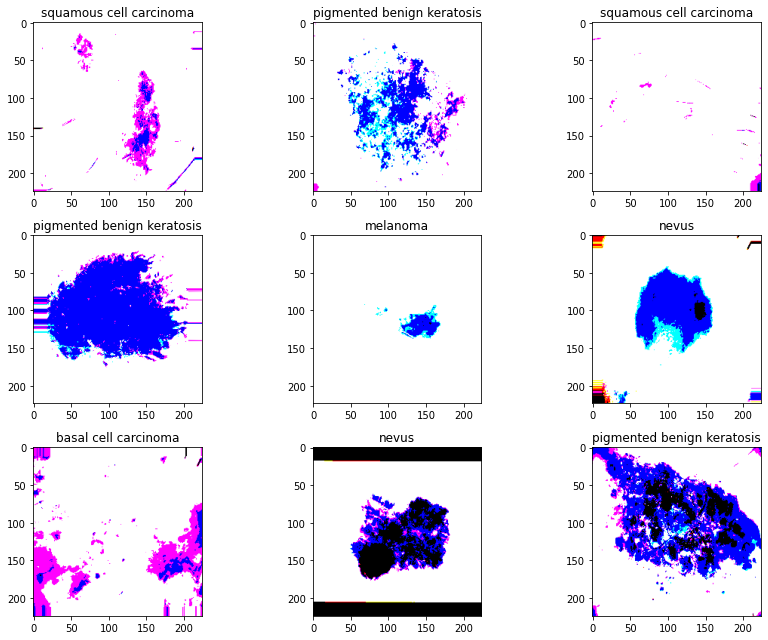

In [42]:
fit, axs = plt.subplots(nrows=3, ncols=3, figsize=(12,9))

for i, a in enumerate(axs.flat):
    img, label = X_train.next()
    a.imshow(img[0],)
    a.set_title(labels[np.where(label[0] == 1)[0][0]])
plt.tight_layout()
plt.show()

### Creating CNN Model

In [44]:
model = Sequential()

### Scale image size to 0.1

In [ ]:
model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255))

### 1. Conv2D layer

In [45]:
model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', input_shape=(224, 224, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding='valid'))

### 2. Conv2D layer

In [46]:
model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding='valid'))

### 3. Conv2D layer

In [47]:
model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding='valid'))

### Scale to 1 dimensional input for NN

In [48]:
model.add(Flatten())

### Hidden fully connected layer

In [49]:
model.add(Dense(256))
model.add(Activation('relu'))

### Inhibit overfitting

In [50]:
model.add(Dropout(0.2))

### Output fully connected layer

In [51]:
model.add(Dense(9))
model.add(Activation('softmax'))

### Compile model

In [52]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [53]:
history = model.fit(X_train, validation_data=X_val, epochs=EPOCHS)

Epoch 1/50
56/56 [==============================] - 55s 971ms/step - loss: 15.8016 - accuracy: 0.2831 - val_loss: 46.9220 - val_accuracy: 0.0424
Epoch 2/50
56/56 [==============================] - 51s 917ms/step - loss: 2.2410 - accuracy: 0.2915 - val_loss: 41.6504 - val_accuracy: 0.0424
Epoch 3/50
56/56 [==============================] - 51s 917ms/step - loss: 1.8882 - accuracy: 0.3540 - val_loss: 22.4105 - val_accuracy: 0.1518
Epoch 4/50
56/56 [==============================] - 51s 913ms/step - loss: 1.8121 - accuracy: 0.3830 - val_loss: 19.8426 - val_accuracy: 0.1875
Epoch 5/50
56/56 [==============================] - 51s 911ms/step - loss: 1.8004 - accuracy: 0.3724 - val_loss: 24.7421 - val_accuracy: 0.2098
Epoch 6/50
56/56 [==============================] - 51s 905ms/step - loss: 1.7676 - accuracy: 0.3735 - val_loss: 18.2236 - val_accuracy: 0.2567
Epoch 7/50
56/56 [==============================] - 51s 915ms/step - loss: 1.7670 - accuracy: 0.3964 - val_loss: 13.0326 - val_accuracy

## Saving the model as a tflite file in order to deploy it in a mobile application.

### Convert the model.

In [54]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpyd653x7p/assets


INFO:tensorflow:Assets written to: /tmp/tmpyd653x7p/assets


### Plotting the accuraccy and loss of Training vs Validation

In [55]:
accuracy = history.history['accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']

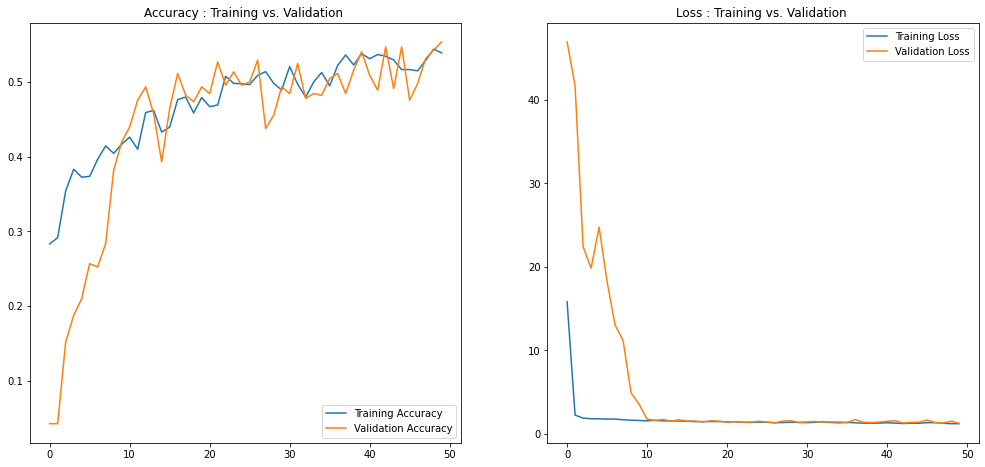

In [56]:
plt.figure(figsize=(17, 17))
plt.subplot(2, 2, 1)
plt.plot(range(EPOCHS), accuracy, label='Training Accuracy')
plt.plot(range(EPOCHS), val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy : Training vs. Validation ')

plt.subplot(2, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.title('Loss : Training vs. Validation ')
plt.legend(loc='upper right')
plt.show()

### Loading testing dataset

In [57]:
X_test = load_dataset('/content/dataset/Test/')

## Shape of Test Data and ordered count of rows per unique label


In [58]:
print('Test Data: ', X_test.shape)

# ordered count of rows per unique label
X_test['Labels'].value_counts(ascending=True)

Test Data:  (118, 2)


seborrheic keratosis           3
vascular lesion                3
actinic keratosis             16
melanoma                      16
dermatofibroma                16
pigmented benign keratosis    16
squamous cell carcinoma       16
basal cell carcinoma          16
nevus                         16
Name: Labels, dtype: int64

In [59]:
# image preprocessing
X_test = img_data_gen.flow_from_dataframe(
    dataframe=X_test,
    x_col='FilePaths',
    y_col='Labels',
    target_size=IMG_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False, # necessary fpr confusion matrix
    seed=1
)

Found 118 validated image filenames belonging to 9 classes.


In [60]:
res = model.evaluate(X_test)

4/4 [==============================] - 9s 2s/step - loss: 3.0716 - accuracy: 0.3305


In [62]:
# accuracy
print(f'Train Accuracy: {history.history["accuracy"][-1:][0] * 100:.2f}')
print(f'Val Accuracy: {history.history["val_accuracy"][-1:][0] * 100:.2f}')
print(f'Test Accuracy: {res[1] * 100:.2f}')
# loss
print(f'Train Loss: {history.history["loss"][-1:][0] * 100:.2f}')
print(f'Val Loss: {history.history["val_loss"][-1:][0] * 100:.2f}')
print(f'Test Loss: {res[0] * 100:.2f}')

Train Accuracy: 53.88
Val Accuracy: 55.36
Test Accuracy: 33.05
Train Loss: 122.64
Val Loss: 125.38
Test Loss: 307.16


In [63]:
# predicted labels
Y_pred = model.predict(X_test)
print("Y_pred", Y_pred.shape)
# rounded labels
y_pred = np.argmax(Y_pred, axis=1)
print("y_pred", y_pred.size)

Y_pred (118, 9)
y_pred 118


In [64]:
# true labels
y_true = X_test.classes
print("y_pred", len(y_pred))
# label classes
class_labels = list(X_test.class_indices.keys())
print("labels", len(class_labels))

y_pred 118
labels 9
